# Lecture 17:  Tensors and tensor decompositions

## Recap of the previous lecture
- Large scale eigenvalue problem
- Krylov methods
- Jacobi-Davidson method
- LOBPCG
- Intro to streaming algorithms

## Today lecture 

- Tensor decompositions and applications


# Tensors

By **tensor** we imply a **multidimensional array**:

$$
A(i_1, \dots, i_d), \quad 1\leq i_k\leq n_k,
$$

where $d$ is called dimension, $n_k$ - mode size.
This is standard definition in applied mathematics community. For details see [[1]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.153.2059&rep=rep1&type=pdf), [[2]](http://arxiv.org/pdf/1302.7121.pdf), [[3]](http://epubs.siam.org/doi/abs/10.1137/090752286).

* $d=2$ (matrices) $\Rightarrow$ classic theory (SVD, LU, QR, $\dots$)

* $d\geq 3$ (tensors) $\Rightarrow$ under development. Generalization of standard matrix results is not  **straightforward**.
<img src="./tensor_dogs.png">

Picture is taken from [this presentation](http://users.cecs.anu.edu.au/~koniusz/tensors-cvpr17/present/anandkumar_anima_tmcv2017.pdf)

## More formal definition

Tensor is a multilinear form. When you fix the basis, you get a $d$-dimensional table.

## Curse of dimensionality

The problem with multidimensional data is that number of parameters grows <font color='red'> exponentially </font> with $d$:


$$
    \text{storage} = n^d.
$$
For instance, for $n=2$ and $d=500$
$$
    n^d = 2^{500} \gg 10^{83}  -  \text{ number of atoms in the Universe}
$$

Why do we care? It seems that we are living in the 3D World :)

## Applications

#### Quantum chemistry

Stationary Schroedinger equation for system with $N_{el}$ electrons

$$
    \hat H \Psi = E \Psi,
$$

where

$$
\Psi = \Psi(\{{\bf r_1},\sigma_1\},\dots, \{{\bf r_{N_{el}}},\sigma_{N_{el}}\})
$$

3$N_{el}$ spatial variables and $N_{el}$ spin variables. 
<img src="./large_mol.jpg" width=600>

* Drug and material design
* Predicting physical experiments

#### Uncertainty quantification

Example: oil reservoir modeling. Model may depend on parameters $p_1,\dots,p_d$ (like measured experimentally porocity or temperature) with uncertainty

$$
u = u(t,{\bf r},\,{p_1,\dots,p_d})
$$

#### And many more

* Signal processing
* Recommender systems
* Neural networks
* Language models
* Financial mathematics
* ...

## Working with many dimensions

How to work with high-dimensional functions?

- **Monte-Carlo**: class of methods based on random sampling. Convergence issues
- **Sparse grids**: special types of grids with small number of grid points. Strong regularity conditions
- **Best N-term approximation** : sparse expansions in certain basis.
- Promising approach based on <font color='red'>tensor decompositions </font>

## Tensor decompositions

## 2D

Skeleton decomposition:
$$
A = UV^T
$$
or elementwise:
$$
a_{ij} = \sum_{\alpha=1}^r u_{i\alpha} v_{j\alpha}
$$
leads us to the idea of **separation of variables.**

**Properties:**
* Not unique: $A = U V^T = UBB^{-1}V^T = \tilde U \tilde V^T$
* Can be calculated in a stable way by **SVD**

## Canonical decomposition

The most straightforward way to generize separation of variables to many dimensions is the **canonical decomposition**: (CP/CANDECOMP/PARAFAC)

$$
a_{ijk} = \sum_{\alpha=1}^r u_{i\alpha} v_{j\alpha} w_{k\alpha}
$$

minimal possible $r$ is called the **canonical rank**. Matrices $U$, $V$ and $W$ are called **canonical factors**. This decomposition was proposed in 1927 by Hitchcock, [link](https://onlinelibrary.wiley.com/doi/abs/10.1002/sapm192761164).

**Properties**:

* For a $d$ dimensional tensor memory is $nrd$
* Unique under mild conditions
* Set of tensors with rank$\leq r$ is not closed (by contrast to matrices): <br>
  $a_{ijk} = i+j+k$, $\text{rank}(A) = 3$, but
  
  $$a^\epsilon_{ijk} = \frac{(1+\epsilon i)(1+\epsilon j)(1+\epsilon k) - 1}{\epsilon}\to i+j+k=a_{ijk},\quad \epsilon\to 0 $$
  
  and $\text{rank}(A^{\epsilon}) = 2$
* No stable algorithms to compute best rank-$r$ approximation

### Alternating Least Squares algorithm

0. Intialize random $U,V,W$
1. fix $V,W$, solve least squares for $U$
2. fix $U,W$, solve least squares for $V$
3. fix $U,V$, solve least squares for $W$
4. go to 2.

### DNN compression ([Lebedev, et. al 2015](https://arxiv.org/pdf/1412.6553.pdf))

- Convolution is represented as 4D tensor
- Apply CP decomposition to this tensor
- Apply one-by-one convolutions with smaller kernels given by CP decomposition
- Fine tune such model

<img src="./cp_compress_dnn.png" width=600>

[[[ 0  1]
  [ 2  3]
  [ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]
  [12 13]
  [14 15]]

 [[16 17]
  [18 19]
  [20 21]
  [22 23]]]


Text(0, 0.5, 'Approximation error')

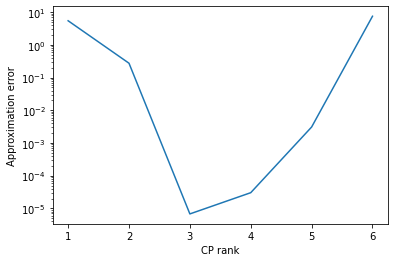

In [2]:
import tensorly as tl
import tensorly.decomposition as tldec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tensor = tl.tensor(np.arange(24).reshape((3, 4, 2)))
# tensor = tl.random.cp_tensor(shape=(3,3,3), rank=3, full=True)
print(tensor)
rank_range = [1, 2, 3, 4, 5, 6]
error_rec = []
for r in rank_range:
    factors = tldec.parafac(tensor.astype("f"), rank=r)
    error_rec.append(np.linalg.norm(tl.kruskal_to_tensor(factors) - tensor))
plt.semilogy(rank_range, error_rec)
plt.xlabel("CP rank")
plt.ylabel("Approximation error")

## Tucker decomposition

Next attempt is the decomposition proposed by ([Tucker, 1963](https://link.springer.com/content/pdf/10.1007/BF02289464.pdf)) in [Psychometrika](https://link.springer.com/journal/11336):

$$
a_{ijk} = \sum_{\alpha_1,\alpha_2,\alpha_3=1}^{r_1,r_2,r_3}g_{\alpha_1\alpha_2\alpha_3} u_{i\alpha_1} v_{j\alpha_2} w_{k\alpha_3}.
$$

Here we have several different ranks. Minimal possible $r_1,r_2,r_3$ are called **Tucker ranks**.

**Properties**:

* For a $d$ dimensional tensor memory is <font color='red'>$r^d$</font> $+ nrd$. Still **curse of dimensionality**
* Stable SVD-based algorithm:
    1. $U =$ principal components of the unfolding `A.reshape(n1, n2*n3)`
    2. $V =$ principal components of the unfolding `A.transpose([1,0,2]).reshape(n2, n1*n3)`
    3. $W =$ principal components of the unfolding `A.transpose([2,0,1]).reshape(n3, n1*n2)`
    4. $g_{\alpha_1\alpha_2\alpha_3} = \sum_{i,j,k=1}^{n_1,n_2,n_3} a_{ijk} u_{i\alpha_1} v_{j\alpha_2} w_{k\alpha_3}$.

In [3]:
tensor = tl.tensor(np.arange(24).reshape((3, 4, 2)))
core, factors = tldec.tucker(tensor, ranks=[3, 4, 2])
print("Shape of core = {}".format(core.shape))
for f in factors:
    print("Shape of factors = {}".format(f.shape))
print("Approximation error = {}".format(np.linalg.norm(tensor - tl.tucker_to_tensor(core, factors))))

Shape of core = (3, 4, 2)
Shape of factors = (3, 3)
Shape of factors = (4, 4)
Shape of factors = (2, 2)
Approximation error = 3.181718859384126e-14


### Application in recommender systems [(Frolov, Oseledets 2016)](https://dl.acm.org/citation.cfm?id=2959170)

- Represent User-Item **matrix** as binary User-Item-Rating **tensor**
- After Tucker decomposition of this tensor we have three factors
- Two of them represent projections on the space of ratings and space of items
- This approach takes into account negative feedback to items from some users

## CP and Tucker decompositions implementations

- Matlab: [Tensorlab](https://www.tensorlab.net/) and [Tensor Toolbox](https://www.sandia.gov/~tgkolda/TensorToolbox/index-2.5.html)
- Python: [TensorLy](http://tensorly.org/stable/home.html) and [Scikit-tensor](https://github.com/mnick/scikit-tensor)

## Tensor Train decomposition

* Calculation of the canonical decomposition is unstable
* Tucker decomposition suffers from the curse of dimensionality

Tensor Train (**TT**) decomposition ([Oseledets, Tyrtyshnikov 2009](http://www.mat.uniroma2.it/~tvmsscho/papers/Tyrtyshnikov4.pdf) and [Oseledets, 2011](https://epubs.siam.org/doi/abs/10.1137/090752286)) is both stable and contains linear in $d$ number of parameters:

$$
a_{i_1 i_2 \dots i_d} = \sum_{\alpha_1,\dots,\alpha_{d-1}} 
g_{i_1\alpha_1} g_{\alpha_1 i_2\alpha_2}\dots g_{\alpha_{d-2} i_{d-1}\alpha_{d-1}} g_{\alpha_{d-1} i_{d}}
$$

or in the matrix form

$$
    a_{i_1 i_2 \dots i_d} = G_1 (i_1)G_2 (i_2)\dots G_d(i_d)
$$

* The storage is $\mathcal{O}(dnr^2)$ 
* Stable TT-SVD algorithm

**Example**
$$a_{i_1\dots i_d} = i_1 + \dots + i_d$$
Canonical rank is $d$. At the same time TT-ranks are $2$:
$$
i_1 + \dots + i_d = \begin{pmatrix} i_1 & 1 \end{pmatrix} 
\begin{pmatrix} 1 & 0 \\ i_2 & 1 \end{pmatrix}
\dots
\begin{pmatrix} 1 & 0 \\ i_{d-1} & 1 \end{pmatrix}
\begin{pmatrix} 1  \\  i_d \end{pmatrix}
$$

### Implementations

- Matlab: [TT Toolbox](https://github.com/oseledets/TT-Toolbox)
- Python: [ttpy](https://github.com/oseledets/ttpy)
- TensorFlow: [t3f](https://github.com/Bihaqo/t3f)
- PyTorch: [tt-pytorch](https://github.com/KhrulkovV/tt-pytorch) and [tntorch](https://github.com/rballester/tntorch)


## Using TT in riemannien optimization (example is from t3f examples)

- Given some TT tensor $A$ with large tt-ranks
- We would like to find a tensor $X$ (with small prescribed tt-ranks $r$) which is closest to $A$ (in the sense of Frobenius norm):
\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}} 
& & \frac{1}{2}\|X - A\|_F^2 \\
& \text{subject to} 
& & \text{tt_rank}(X) = r
\end{aligned}
\end{equation*}

- It is known that the set of TT tensors with elementwise fixed TT ranks forms a manifold. 
- Thus we can solve this problem using the so called Riemannian gradient descent. 

### Riemannian gradient descent

- Given some functional $F$ on a manifold $\mathcal{M}$ Riemannian gradient descent is defined as

$$\hat{x}_{k+1} = x_{k} - \alpha P_{T_{x_k}\mathcal{M}} \nabla F(x_k),$$

$$x_{k+1} = \mathcal{R}(\hat{x}_{k+1})$$

with $P_{T_{x_k}\mathcal{M}}$ being the projection onto the **tangent space** of $\mathcal{M}$ at the point $x_k$ and $\mathcal{R}$ being a **retraction** - an operation which projects points to the manifold, and $\alpha$ is the learning rate.

- We can implement this in `t3f` using the `t3f.riemannian` module. As a retraction it is convenient to use the rounding method (`t3f.round`).

In [3]:
import t3f
import tensorflow as tf
tf.set_random_seed(0)
np.random.seed(0)
sess = tf.InteractiveSession()

# Initialize A randomly, with large tt-ranks
shape = 10 * [2]
init_A = t3f.random_tensor(shape, tt_rank=16)
A = t3f.get_variable('A', initializer=init_A, trainable=False)

# Create an X variable and compute the gradient of the functional. Note that it is simply X - A.

init_X = t3f.random_tensor(shape, tt_rank=2)
X = t3f.get_variable('X', initializer=init_X)

gradF = X - A

In [4]:
# Let us compute the projection of the gradient onto the tangent space at X
riemannian_grad = t3f.riemannian.project(gradF, X)

# Compute the update by subtracting the Riemannian gradient
# and retracting back to the manifold
alpha = 1.0

train_step = t3f.assign(X, t3f.round(X - alpha * riemannian_grad, max_tt_rank=2))

# let us also compute the value of the functional
# to see if it is decreasing
F = 0.5 * t3f.frobenius_norm_squared(X - A)

In [5]:
sess.run(tf.global_variables_initializer())

log = []
for i in range(100):
    F_v, _ = sess.run([F, train_step.op])
    if i % 10 == 0:
        print (F_v)
    log.append(F_v)

81.62205
58.53462
56.27
56.08319
51.73249
50.77673
50.77672
50.77671
50.77672
50.77672


It is intructive to compare the obtained result with the quasioptimum delivered by the TT-round procedure. 

In [6]:
quasi_sol = t3f.round(A, max_tt_rank=2)

val = sess.run(0.5 * t3f.frobenius_norm_squared(quasi_sol - A))
print (val)

52.40742


We see that the value is slightly bigger than the exact minimum, but TT-round is faster and cheaper to compute, so it is often used in practice.

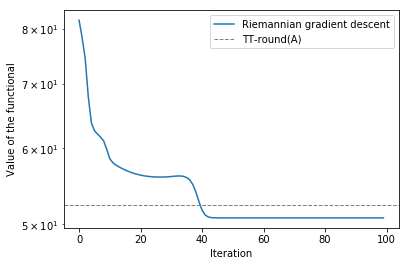

In [7]:
plt.semilogy(log, label='Riemannian gradient descent')
plt.axhline(y=val, lw=1, ls='--', color='gray', label='TT-round(A)')
plt.xlabel('Iteration')
plt.ylabel('Value of the functional')
plt.legend()

### Exponential machines ([Novikov et al 2017](https://arxiv.org/pdf/1605.03795.pdf))

- Linear model depends on vector 

$$ \hat{y}_l(x) = \langle w, x \rangle + b$$ 

- Exponential machine depends on tensor $W$

$$\hat{y}_{expm}(x) = \sum_{i_1 = 0}^1 \ldots \sum_{i_d = 0}^1 W_{i_1, \ldots, i_d} \prod_{k=1}^d x_k^{i_k}$$

- Represent tensor $W$ in TT-format and control TT-rank 
- Learning of this model is loss minimization with constraint on the tensor rank - riemannien optimization again

## Quantized Tensor Train

Consider a 1D array $a_k = f(x_k)$, $k=1,\dots,2^d$ where $f$ is some 1D function calculated on grid points $x_k$.

Let $$k = {2^{d-1} i_1 + 2^{d-2} i_2 + \dots + 2^0 i_{d}}\quad i_1,\dots,i_d = 0,1 $$ 
be binary representation of $k$, then

$$
    a_k = a_{2^{d-1} i_1 + 2^{d-2} i_2 + \dots + 2^0 i_{d}} \equiv \tilde a_{i_1,\dots,i_d},
$$

where $\tilde a$ is nothing, but a reshaped tensor $a$. TT decomposition of $\tilde a$ is called **Quantized Tensor Train (QTT)** decomposition. 

Interesting fact is that the QTT decomposition has relation to wavelets, more details see [here](https://epubs.siam.org/doi/abs/10.1137/100811647).

Contains <font color='red'>$\mathcal{O}(\log n r^2)$</font> elements!

## Cross approximation method

- If decomposition of a tensor is given, then there is no problem to do basic operations fast. 

- However, the question is if it is possible to find decomposition taking into account that typically tensors even can not be stored. 

- **[Cross approximation](https://ac.els-cdn.com/S0024379509003747/1-s2.0-S0024379509003747-main.pdf?_tid=0739e049-650f-4fed-8087-61563927f6ac&acdnat=1544040611_b7cd24f6dd7a48d85665d6b562129ab4)** method allows to find the decomposition using only few of its elements (more details in the blackboard).

## Tensor networks

- Universal way for writing tensor decompositions
- Can be interpreted as special neural network architecture
- Some theoretical results on DNN expressive power can be derived with tensor network framework, see an example [here](https://arxiv.org/pdf/1711.00811.pdf)
- [tntorch](https://github.com/rballester/tntorch) combines tensor networks and PyTorch
- More details see [here](https://arxiv.org/pdf/1609.00893.pdf) and [here](https://arxiv.org/abs/1708.09165)

## Summary 

* Tensor decompositions - useful tool to work with multidimensional data
* Canonical, Tucker, TT, QTT decompositions
* Cross approximation

## Next week

- Exam: Monday and Tuesday

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()